# Load trained model parameters on new abstracts.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER-V2'
%cd $path
import random
import utils_train as ut
import net
from transformers import BertForMaskedLM, BertTokenizer
import torch
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
/content/drive/MyDrive/elsevier/Bert-NER-V2


In [ ]:
!pip install scholarly

In [7]:
from scholarly import scholarly
search_query = scholarly.search_pubs('machine learning interatomic potential', year_low=2024)
scholarly.pprint(next(search_query))

KeyboardInterrupt: 

In [ ]:
example = "In recent years, many types of machine learning potentials (MLPs) have been introduced, which are able to represent high-dimensional potential-energy surfaces (PESs) with close to first-principles accuracy. Most current MLPs rely on atomic energy contributions given as a function of the local chemical environments. Frequently, in addition to total energies, atomic forces are also used to construct the potentials, as they provide detailed local information about the PES. Since many systems are too large for electronic structure calculations, obtaining reliable reference forces from smaller subsystems, such as molecular fragments or clusters, can substantially simplify the construction of the training sets. Here, we propose a method to determine structurally converged molecular fragments, providing reliable atomic forces based on an analysis of the Hessian. The method, which serves as a locality test and allows us to estimate the importance of long-range interactions, is illustrated for a series of molecular model systems and the metal–organic framework MOF-5 as an example for a complex organic–inorganic hybrid material."

## Load parameters

In [ ]:
CLASSES = {'MATERIAL': 1, 'MLIP': 2, 'PROPERTY': 3,
           'VALUE': 4, 'APPLICATION': 5, 'O': 0}
SEED = 32
MAX_LENGTH = 512
ut.seed_everything(SEED)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)
parameter_path = path + '/saved_models/test_model.pt'
model.load_state_dict(torch.load(parameter_path))
model.eval()
print('Model loaded')

Model loaded


## Feed text to model

In [ ]:
def inference(text_test, model, tokenizer, max_length):
    text_list = ut.split_para(text_test)
    token_list = tokenizer.convert_tokens_to_ids(text_list)
    data_test = torch.tensor(token_list + [0] * (max_length - len(token_list)))[None, :]
    att_mask_test = torch.tensor([1] * len(text_list) + [0] * (max_length - len(text_list)))[None, :]
    y_pred_test = model(data_test, attention_mask=att_mask_test)
    y_pred_test = torch.swapaxes(y_pred_test, 1, 2)
    pred = y_pred_test.max(dim=1)[1][0][:len(text_list)]
    return pred, text_list
pred, text_list = inference(example, model, tokenizerBERT, MAX_LENGTH)

# Show prediction

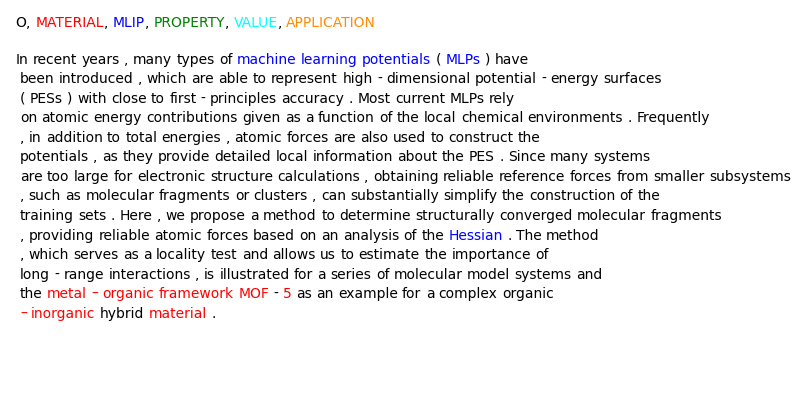

In [ ]:
colors = ['black', 'red', 'blue', 'green', 'cyan', 'darkorange']
word_list_marked = ['<' + w + '>' for w in text_list]
markers = [{"color": colors[i]} for i in pred]
j = 0
for i in range(len(text_list)):
    if (i + 1) % 15 == 0:
        word_list_marked.insert(i + j, '\n')
        j += 1
fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <VALUE>, <APPLICATION>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
              highlight_textprops=markers, ax=ax)
plt.show()